In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf 
# Load data for SPY from Yahoo Finance
df = yf.download('SPY', start='2012-04-29', end='2022-04-29')





# Normalize the data
scaler = MinMaxScaler()
df['Normalized_Price'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Split the data into training, validation, and testing sets
train_data = df.iloc[:int(0.6*len(df))]
valid_data = df.iloc[int(0.6*len(df)):int(0.8*len(df))]
test_data = df.iloc[int(0.8*len(df)):]

# Convert the data into PyTorch tensors
train_inputs = torch.tensor(train_data['Normalized_Price'].values).float()
train_targets = torch.tensor(train_data['Normalized_Price'].values[1:]).float()

val_inputs = torch.tensor(valid_data['Normalized_Price'].values).float()
val_targets = torch.tensor(valid_data['Normalized_Price'].values[1:]).float()

test_inputs = torch.tensor(test_data['Normalized_Price'].values).float()
test_targets = torch.tensor(test_data['Normalized_Price'].values[1:]).float()

# Define the BRT model
class BRT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(BRT, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.TransformerEncoderLayer(hidden_dim, nhead=4)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.encoder(x)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        x = self.decoder(x)
        x = self.dropout(x)
        return x

# Define the training loop
def train(model, train_data, valid_data, num_epochs, batch_size, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        # Train the model
        train_loss = 0.0
        for i in range(0, len(train_data)-batch_size, batch_size):
            inputs = train_data[i:i+batch_size]['Normalized_Price'].values
            targets = train_data[i+1:i+1+batch_size]['Normalized_Price'].values
            inputs = torch.tensor(inputs.reshape(batch_size, -1, 1)).float()
            targets = torch.tensor(targets.reshape(batch_size, -1, 1)).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size
        train_loss /= len(train_data)
        train_losses.append(train_loss)

        # Evaluate the model on the test set
        valid_loss = 0.0
        with torch.no_grad():
            for i in range(0, len(valid_data)-batch_size, batch_size):
                inputs = valid_data[i:i+batch_size]['Normalized_Price'].values
                targets = valid_data[i+1:i+1+batch_size]['Normalized_Price'].values
                inputs = torch.tensor(inputs.reshape(batch_size, -1, 1)).float()
                targets = torch.tensor(targets.reshape(batch_size, -1, 1)).float()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item() * batch_size
        valid_loss /= len(valid_data)
        valid_losses.append(valid_loss)

        print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss, valid_loss))

    return train_losses, valid_losses

# Initialize the model and set the hyperparameters
input_dim = 1
hidden_dim = 32
output_dim = 1
num_layers = 2
dropout = 0.2
learning_rate = 0.00001
num_epochs = 50
batch_size = 1

model_brt = BRT(input_dim, hidden_dim, output_dim, num_layers, dropout)

# Train the model
train_losses, test_losses = train(model_brt, train_data, valid_data, num_epochs, batch_size, learning_rate)

# Evaluate the model on the test set
model_brt.eval()
with torch.no_grad():
    criterion = nn.MSELoss()
    inputs = test_data['Normalized_Price'].values[:-1]
    targets = test_data['Normalized_Price'].values[1:]
    inputs = torch.tensor(inputs.reshape(-1, 1, 1)).float()
    targets = torch.tensor(targets.reshape(-1, 1, 1)).float()
    outputs = model_brt(inputs)
    test_loss = criterion(outputs, targets).item()




[*********************100%***********************]  1 of 1 completed
Epoch [1/50], Train Loss: 0.0241, Valid Loss: 0.0736
Epoch [2/50], Train Loss: 0.0174, Valid Loss: 0.0556
Epoch [3/50], Train Loss: 0.0149, Valid Loss: 0.0508
Epoch [4/50], Train Loss: 0.0138, Valid Loss: 0.0586
Epoch [5/50], Train Loss: 0.0134, Valid Loss: 0.0540
Epoch [6/50], Train Loss: 0.0126, Valid Loss: 0.0512
Epoch [7/50], Train Loss: 0.0120, Valid Loss: 0.0504
Epoch [8/50], Train Loss: 0.0121, Valid Loss: 0.0508
Epoch [9/50], Train Loss: 0.0123, Valid Loss: 0.0526
Epoch [10/50], Train Loss: 0.0113, Valid Loss: 0.0485
Epoch [11/50], Train Loss: 0.0113, Valid Loss: 0.0550
Epoch [12/50], Train Loss: 0.0128, Valid Loss: 0.0526
Epoch [13/50], Train Loss: 0.0124, Valid Loss: 0.0427
Epoch [14/50], Train Loss: 0.0130, Valid Loss: 0.0522
Epoch [15/50], Train Loss: 0.0122, Valid Loss: 0.0473
Epoch [16/50], Train Loss: 0.0110, Valid Loss: 0.0477
Epoch [17/50], Train Loss: 0.0120, Valid Loss: 0.0542
Epoch [18/50], Train L

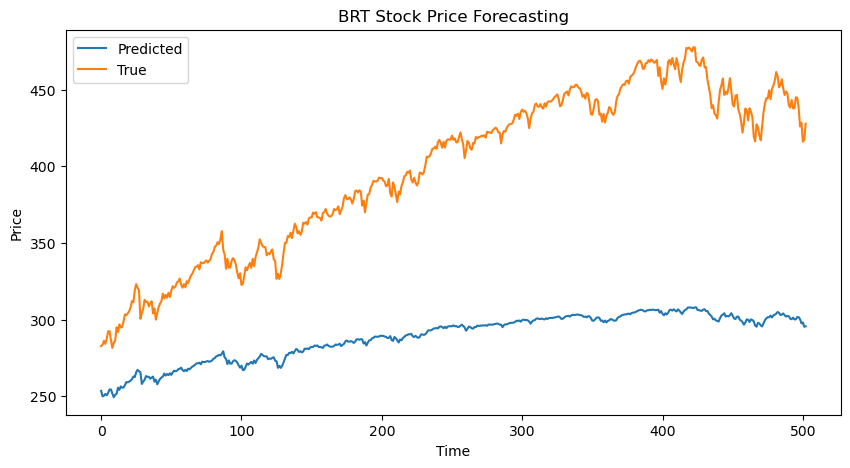

In [28]:
# Inverse transform the predictions and targets
outputs = scaler.inverse_transform(outputs.reshape(-1, 1)).squeeze()
targets = scaler.inverse_transform(targets.reshape(-1, 1)).squeeze()
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(outputs, label='Predicted')
plt.plot(targets, label='True')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('BRT Stock Price Forecasting')
plt.legend()
plt.show()